In [1]:
import numpy as np
import matplotlib.pyplot as pl
import jhu2016_labs.plotting as plotting
import jhu2016_labs.models as models

%matplotlib inline

## Training data 

In real world scenario, we observe a set of data (often called features), and we wish to learn some model that can "explain" the observed features. Generally, we do not know the true distribution of the features. For this lab we will simulate a set of single dimensional features sampled from a GMM. We will call this GMM the "true model" and in this notebook we will see different strategies to approximate the true model from the simulated training data.    

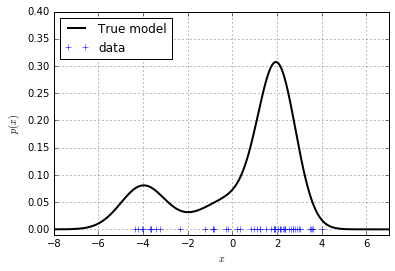

In [2]:
true_model = models.GMM([-4, 0, 2], [1, 2, .7], [0.2, 0.2, 0.6])
X = true_model.sampleData(50)
Y = np.zeros_like(X) # The random variable has a single dimension!
x_min = -8
x_max = 7
y_min = -0.01
y_max = .4
fig, ax = plotting.plotGMM(true_model, x_min=x_min, x_max=x_max, y_min=y_min, y_max=y_max, 
                           label='True model')
ax.plot(X, Y, '+', color='b', label='data')
ax.legend(loc='upper left')

## Gaussian density 

We can first try to model the observed data with a Gaussian distribution. The Gaussian density function is defined as:
$$
\DeclareMathOperator{\Norm}{\mathcal{N}}
\DeclareMathOperator{\Gam}{Gam}
\DeclareMathOperator{\e}{exp}
p(x \mid \mu, \sigma^2) = \Norm(x \mid \mu, \sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}} \e\{ \frac{-(x - \mu)^2}{2\sigma^2} \}
$$
* $\mu$ is the **mean** of the Gaussian density 
* $\sigma^2$ is the **variance** of the Gaussian density


##### TODO
Try to play with the mean and the variance of the Gaussian. How does each parameter change the density?

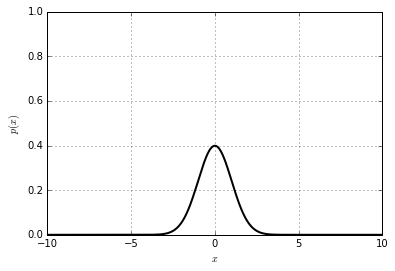

In [3]:
gaussian = models.Gaussian(0., 1.) # <- 1st parameter is mean, second variance0
fig, ax = plotting.plotGaussian(gaussian)

Alternatively, the Gaussian density function can be parameterized with a precision $\lambda$ which is the inverse of the variance:
$$
    \DeclareMathOperator{\e}{exp}
    p(x | \mu, \lambda) = \Norm(x \mid \mu, \lambda^{-1}) = \frac{\sqrt{\lambda}}{\sqrt{2\pi}} \e\{ \frac{-\lambda(x - \mu)^2}{2} \}
$$
* $\mu$ is the **mean** of the Gaussian density 
* $\lambda = \frac{1}{\sigma^2}$ is the **precision** of the Gaussian density

This alternative parameterization will prove to be useful when dealing with Bayesian inference for the Gaussian/GMM density.

### Maximum Likelihood estimation

We will first try to model our data with a simple Gaussian. We need to find the parameters (mean and variance) that best fit/explain the data. Here're the ML estimation formulas:

$$
\begin{align}
\mu &= \frac{1}{N} \sum_i x_i \\
\sigma^2 &= \frac{1}{N} \sum_i x_i^2
\end{align}
$$

##### TODO
From the above equations, implement the maximum-likelihood estimation solution for the Gaussian. Does the Gaussian seem to be a good model for the true density ?

correct solution !
('log-likelihood:', -116.7638731149421)


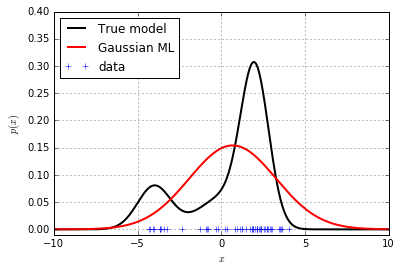

In [4]:
##########################
# Write your code here. 
mean_ml = sum(X)/len(X)
var_ml = sum(X**2)/len(X)
##########################

# Check your solutions uncomment the following code
test_gaussian_ml = models.Gaussian.maximumLikelihood(X)
assert np.isclose(test_gaussian_ml.mean, mean_ml), 'incorrect mean'
assert np.isclose(test_gaussian_ml.var, var_ml), 'incorrect variance'
print('correct solution !')
gaussian_ml = models.Gaussian(mean_ml, var_ml)
llh = gaussian_ml.logLikelihood(X)
print('log-likelihood:', llh)

y_min = -.01
y_max = .4
fig, ax = plotting.plotGMM(true_model, y_min=y_min, y_max=y_max, label='True model')
plotting.plotGaussian(gaussian_ml, fig=fig, ax=ax, color='red', label='Gaussian ML')
ax.plot(X, Y, '+', color='b', label='data')
ax.legend(loc='upper left')

### Bayesian Inference

We can work within the Bayesian framework with the Gaussian density by putting a prior over the mean and precision. A common and convenient choice of prior for the Gaussian is the **Normal-Gamma** prior:

$$
p(\mu, \lambda \mid m_0, \kappa_0, a_0, b_0) = \Norm(\mu \mid m_0, (\kappa_0 \lambda)^{-1}) \Gam(\lambda \mid a_0, b_0)
$$

where:

$$
\Gam(\lambda \mid a_0, b_0) = \frac{1}{\Gamma(a_0)} b_0^{a_0} \lambda^{a_0 - 1} \e \{ -b_0 \lambda\}
$$

$m_0$, $\kappa_0$, $a_0$ and $b_0$ are called **hyper-parameters**. They are the parameters of the prior distribution.

##### TODO
Play with the parameters of the Normal-Gamma. How does each parameter affects the density ?

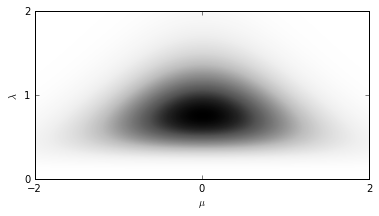

In [5]:
# m_0 is our prior mean (expected value) for mu
# kappa_0 is how strongly we believe in m_0 (related to variance of m_0)
# a_0 is proportional to prior mean for lambda
# b_0 is how stronlgy we believe in a_0

ng_prior = models.NormalGamma(0, 2, 5, 6)
x_min =-2.
x_max = 2.
y_min = 0.
y_max = 2
plotting.plotNormalGamma(ng_prior, x_min=x_min, x_max=x_max, y_min=y_min, y_max=y_max)

Because the Normal-Gamma is the **conjugate prior** of the Normal density (with unknown mean and precision), the posterior distribution $p(\mu, \lambda \mid \mathbf{x})$ has a closed form solution:

$$
p(\mu, \lambda \mid \mathbf{x}) = \Norm(\mu \mid m_n, (\kappa_n \lambda)^{-1}) \Gam(\lambda \mid a_n, b_n)
$$

where:

$$
\begin{align}
m_n &= \frac{\kappa_0 m_0 + N \bar{x}} {\kappa_0 +  N} \\
\kappa_n &= \kappa_0 + N \\
a_n &= a_0 + \frac{N}{2} \\
b_n &= b_0 + \frac{N}{2} ( s + \frac{\kappa_0 (\bar{x} - m_0)^2}{\kappa_0 + N} ) \\
\bar{x} &= \frac{1}{N} \sum_i x_i \\
s &= \frac{1}{N} \sum_i (x_i - \bar{x})^2
\end{align}
$$

$N$ is the total number of observations in the the training data and $m_n$, $\kappa_n$, $a_n$ and $b_n$ are the parameters of the posterior. Note that they are different from the hyper-parameters! The posterior distribution parameters are updated versions of the prior hyperparameters based on training data.

##### TODO
Compute the posterior distribution with 1, 5, 10, 20 and 50 data points from the training data. What do you observe ?

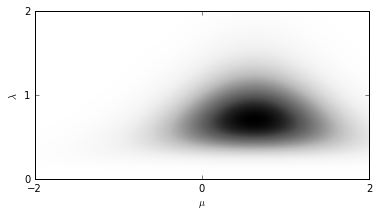

In [6]:
ng_prior = models.NormalGamma(0, 2, 5, 6)
ng_posterior = ng_prior.posterior(X[:1]) # <- Change '1' to the number of sample you want to use 
x_min =-2
x_max = 2
y_min = 0.
y_max = 2
plotting.plotNormalGamma(ng_posterior, x_min=x_min, x_max=x_max, y_min=y_min, y_max=y_max)

### Predictive probability

Now that we have our posterior distibution we can predict the probability of a new data point given the training data:

$$
p(x' \mid \mathbf{x}) = \int p(x' \mid \theta) p(\theta \mid \mathbf{x}) d \theta
$$

For the Gaussian with Normal-Gamma prior the marginal predictive distribution is the Student's t distribution:

$$
\newcommand{\diff}{\mathop{}\!d}
\DeclareMathOperator{\St}{\mathcal{St}}
p(x' \mid \mathbf{x}) = \int_{-\infty}^{\infty} p(x|\mu, \lambda) p(\mu, \lambda \mid \mathbf{x}) \diff \mu \diff \lambda  = \St(x' \mid \mu_n, \nu, \gamma)
$$

where:

$$
\begin{align}
\nu &= 2a_n \\
\gamma &= \frac{a_n \kappa_n}{b_n(\kappa_n + 1)} \\
\St(x' \mid \mu_n, \nu, \gamma) &= \frac{\Gamma(\frac{\nu}{2} + \frac{1}{2})}{\Gamma(\frac{\nu}{2})} \Big( \frac{\gamma}{\pi \nu} \Big)^{\frac{1}{2}} \Big[ 1 + \frac{\gamma (x - \mu_n)^2}{\nu} \Big]^{-\frac{\nu}{2} - \frac{1}{2}}
\end{align}
$$

##### TODO
Compute the log-likelihood of the predictive distribution derived from a posterior trained with 1, 5, 10, 20  and 50 data points. How does it compare to the log-likelihood of the Gaussian trained with maximum likelihood? (Hint: as the name suggests, maximum likelihood estimation strives for MAXIMUM likelihood)

In [7]:
ng_posterior = ng_prior.posterior(X[:1]) # <- Change '1' by the number of sample you want to use.
predict_pdf = ng_posterior.predictiveDensity()  
llh = predict_pdf.logLikelihood(X)
print('log-likelihood:', llh)

('log-likelihood:', -136.21459274338693)


## Gaussian Mixture Model (GMM)

The Gaussian density is a very simple function; however, in most cases of interest the density we try to model has a complex shape that cannot be expressed with a simple formula. A solution is to assume that our complex density is made of $K$ Gaussian densities. This is called a Gaussian Mixture Model (GMM) and it is defined as:
$$
    p(x|\boldsymbol{\mu}, \boldsymbol{\lambda}, \boldsymbol{\pi}) = \sum_{k=1}^{K} \pi_k \Norm(x|\mu_k, (\lambda_k)^{-1})
$$
* $\boldsymbol{\mu}$ is the vector of $K$ means
* $\boldsymbol{\lambda}$ is the vector of $K$ precisions
* $\boldsymbol{\pi}$ is the vector of $K$ weights such that $\sum_{k=1}^K \pi_k = 1$ 

##### TODO
Observe the influence of each parameters on the density and add/remove some components. Does this model suffer from the same drawbacks of the Gaussian density ?

(<matplotlib.figure.Figure at 0x7ffb2077e5d0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7ffb20778450>)

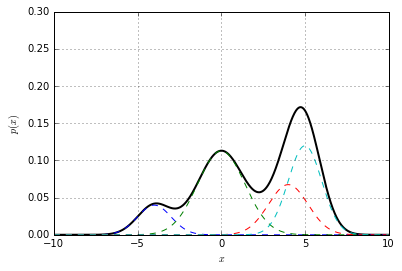

In [8]:
# Change the initial values of the parameters. 
# you can add a component by removing a mean, a variance 
# and a weight. All arrays shall always have the same number 
# of elements ! Be careful, make sure that the sum of weight 
# always sum up to one.
means = [-4.0, 0.0, 4.0, 5]
variances = [1.0, 2.0, 1.4, 1]
weights = [0.1, 0.4, 0.2, 0.3]
gmm = models.GMM(means, variances, weights)

y_min = 0.
y_max = .3
plotting.plotGMM(gmm, show_components=True, y_min=y_min, y_max=y_max)

## Maximum Likelihood estimation

The GMM parameters can be estimated with the **Expectation-Maximization** (EM) algorithm. The EM algorithm is an iterative algorithm that converges toward a (local) maximum of the log-likelihood of the data given the model. The EM training is as follows:
* initialize the parameters of the GMM 
* iterate until convergence:
    * Expectation (E-step): compute the probability of the latent variable for each data point
    * Maximization (M-step): update the parameters from the statistics of the E-step. 

##### TODO
* We have implemented a simple version of the EM algorithm that iterates 10 times. Change the following code to iterate until convergence of the log-likelihood. We will consider that the log-liklihood has converged if $ \log p(\mathbf{x} | \theta^{new}) - \log p(\mathbf{x} | \theta^{old}) \le 0.01$. 
* Run the EM algorithm with different initialization: is the final log-likelihood always the same? What can you conclude? Is the log-likelihood greater than the one from the single Gaussian estimated with Maximum-Likelihood?

('initial log-likelihood:', -129.93339764497188)
('log-likelihood:', -99.005793843823781)
('log-likelihood:', -98.08022452620196)
('log-likelihood:', -97.408102284687317)
('log-likelihood:', -96.85155290300284)
('log-likelihood:', -96.65477391901382)
('log-likelihood:', -96.59121120818655)
('log-likelihood:', -96.549984004665177)
('log-likelihood:', -96.518821670121355)
('log-likelihood:', -96.493497247237443)
('log-likelihood:', -96.472043175085815)


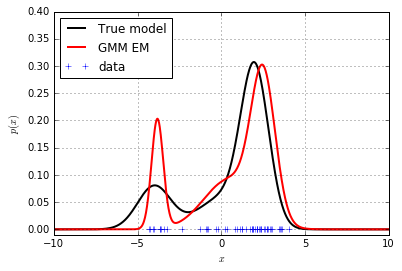

In [9]:
# Initialization of the model
means = [-4.0, 0.0, 4.0]
variances = [1.0, 1.0, 1.]
weights = [0.3, 0.4, 0.3]
gmm = models.GMM(means, variances, weights)

## EM algorithm
print('initial log-likelihood:', gmm.logLikelihood(X))
############################################
# Change this loop to check the convergence of the EM .
for i in range(10):
    # E-step
    Z = gmm.EStep(X)
    
    # M-step
    gmm.MStep(X, Z)
    
    llh = gmm.logLikelihood(X)
    print('log-likelihood:', llh)
##############################################

y_min = -0.01
y_max = .4
fig, ax = plotting.plotGMM(true_model, y_min=y_min, y_max=y_max, label='True model')
plotting.plotGMM(gmm, fig=fig, ax=ax, color='r', label='GMM EM')
ax.plot(X, Y, '+', color='b', label='data')
ax.legend(loc='upper left')

## Bayesian GMM

We can also apply Bayesian inference to estimating GMM by putting a prior over the GMM parameters. Let $\Theta$ be the set of parameters of the GMM:
$$
\Theta = \{ \boldsymbol{\mu}, \boldsymbol{\lambda}, \boldsymbol{\pi} \}
$$

The prior over the weights $\boldsymbol{\pi}$ will be a Dirichlet distribution:

$$
\DeclareMathOperator{\Dir}{Dir}
p(\boldsymbol{\pi}) = \Dir(\boldsymbol{\pi} \mid \boldsymbol{\alpha}_0)
$$

and the prior of the mean and precision of the component $k$ of the mixture will be a Normal-Gamma distribution:

$$
p(\mu_k, \lambda_k) = \Norm(\mu_k \mid m_0, (\kappa_0 \lambda_k)^{-1}) \Gam(\lambda_k \mid a_0, b_0)
$$

The joint distribution of the data, the latent variables and the parameters can be written as:

$$
\begin{align}
p(\mathbf{x}, \mathbf{z}, \Theta) &= p(\mathbf{x}, \mathbf{z} \mid \Theta)p(\Theta) \\
                      &= \Bigg[ \prod_{i=0}^{N} p(x_i \mid \boldsymbol{\mu}, \boldsymbol{\lambda}, \boldsymbol{\pi}) \Bigg] \Bigg[ \Dir(\boldsymbol{\pi} \mid \boldsymbol{\alpha}_0) \prod_{k=0}^{K} \Norm(\mu_k \mid m_0, (\kappa_0 \lambda_k)^{-1}) \Gam(\lambda_k \mid a_0, b_0) \Bigg]
\end{align}
$$

### Gibbs Sampling:

The EM algorithm cannot be applied directly to train the Bayesian GMM. Instead, we will use Gibbs Sampling (GS) to learn the posterior distribution of the parameters. Gibbs Sampling is a simple way to sample values from a complex joint distribution by sequentially sampling from conditional distributions. Let's say that we want to sample values of the random variable $A$ and $B$ conditioned on $C$. Unfortunately, $p(A, B \mid C)$ is too complex to be sampled from directly. Alternatively we can sample in turn $a$ from $p(A | B = b, C)$ and $b$ from $p(B | A=a, C)$. It can be proven that if we keep sampling long enough, the set of $a$ and $b$ will be distributed according to $p(A, B | C)$. This is the Gibbs Sampling algorithm. 

NOTE: Gibbs Sampling is not always applicable as we cannot always sample from the conditional distributions (it may be intractable).

Here we just show the 3 conditional distributions we need for the Gibbs sampling of the Bayesian GMM. The following derivations make frequent use of conditional independence between variables from the graphical model of Bayesian GMM. For illustration purpose, we only perform "blocked" Gibbs sampling, i.e. we jointly sample the mean and variance in one step (pretending they're one variable in the conditional distributions). 


##### latent variable (mixture id)
$$
\begin{align}
p(z_i \mid \mathbf{x}, \Theta) &= p(z_i \mid x_i, \boldsymbol{\pi}, \boldsymbol{\mu}, \boldsymbol{\lambda}) \\
p(z_i = k \mid x_i, \boldsymbol{\pi}, \boldsymbol{\mu}, \boldsymbol{\lambda}) &= \frac{\pi_k \Norm(x_i \mid \mu_k, \lambda_k)} {\sum_{j=0}^{K} \pi_j \Norm(x_i \mid \mu_j, \lambda_j)}
\end{align}
$$

###### mean and variance
We define the set of all data point $x_i$  that are assigned to the component $k$ of the mixture as follows:
$$
\mathbf{x}_{(k)} = \{ x_i : z_i = k, \forall i \in \{1,... , N \} \} 
$$
and similarly for the latent variables $\mathbf{z}$:
$$
\mathbf{z}_{(k)} = \{ z_i : z_i = k, \forall i \in \{1,... , N \} \} 
$$

$$
\begin{align}
p(\mu_k, \lambda_k \mid \mathbf{x}, \mathbf{z}, \Theta_{\smallsetminus \{ \mu_k, \lambda_k \} } ) &= p(\mu_k, \lambda_k \mid \mathbf{x}_{(k)}, \mathbf{z}_{(k)}, \Theta_{\smallsetminus \{ \mu_k, \lambda_k \} } ) \\
&= p(\mu_k, \lambda_k \mid \mathbf{x}_{(k)}, \mathbf{z}_{(k)} ) \\
&= \Norm(\mu_k \mid m_{n,k}, (\kappa_{n,k} \lambda_k)^{-1}) \Gam(\lambda_k \mid a_{n,k}, b_{n,k})
\end{align}
$$

where:

$$
\begin{align}
m_{n,k} &= \frac{\kappa_0 m_0 + N_k \bar{x}_k} {\kappa_0 +  N_k} \\
\kappa_{n,k} &= \kappa_0 + N_k \\
a_{n,k} &= a_0 + \frac{N_k}{2} \\
b_{n,k} &= b_0 + \frac{N_k}{2} ( s + \frac{\kappa_0 (\bar{x}_k - m_0)^2}{\kappa_0 + N_k} ) \\
N_k &= \left\vert \mathbf{x}_{(k)} \right\vert \\
\bar{x}_k &= \frac{1}{N_k} \sum_{\forall x \in \mathbf{x}_{(k)}} x \\
s_n &= \frac{1}{N} \sum_{\forall x \in \mathbf{x}_{(k)}} (x_i - \bar{x})^2
\end{align}
$$

NOTE: these equations simply perform the Bayesian update for the kth Gaussian (based only on data points assigned to the kth mixture); the formulas are otherwise the same as the ones we gave earlier in [5].

##### weights

$$
\begin{align}
p( \boldsymbol{\pi} \mid \mathbf{x}, \mathbf{z}, \Theta_{\smallsetminus \{ \boldsymbol{\pi} \} } ) &= p( \boldsymbol{\pi} \mid \mathbf{z}) \\
&= \Dir(\boldsymbol{\pi} \mid \boldsymbol{\alpha_n})
\end{align}
$$
where:
$$
\alpha_{n,k} = \alpha_{0,k} + N_k \; ; \; \forall \, k = 1\dots K 
$$

##### TODO
* Compare the following implementation of Gibbs Sampling to the EM algorithm. What are their differences/similarities?
* Run the Gibbs Sampling algorithm for 1, 2, 5, 10, 20, ... iterations. How many iterations do we need to get a reasonable estimate of the true density?
* Change the hyper-parameters and run the Gibbs Sampling algorithm for 3 iterations. Are the initial sampled GMMs very similar? Run more iterations; does Gibbs sampling converge to the same solution regardless of the initialization? 

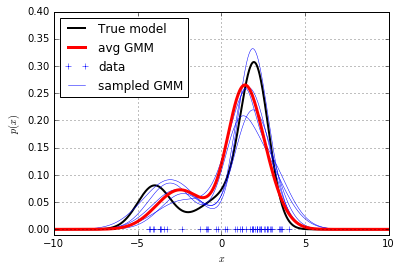

In [10]:
# hyper-parameters [pi_1, pi_2, ...], m, kappa, a, b
# you may try to change this.
bgmm = models.BayesianGMM([1, 1, 1], 0, 1, 2, 1)

y_min = -0.01
y_max = .4
fig, ax = plotting.plotGMM(true_model, y_min=y_min, y_max=y_max, label='True model')

for i in range(5):
    # Sample the latent variables
    Z = bgmm.sampleLatentVariables(X)
    
    # Update the parameters
    bgmm.sampleMeansVariances(X, Z)
    bgmm.sampleWeights(Z)
    
    # Just for plotting, this is not part of the Gibbs Sampling algorithm.
    plotting.plotGMM(bgmm.gmm, fig=fig, ax=ax, color='b', lw=.5, label='sampled GMM')
    
gmm_avg = bgmm.averageGMM()
plotting.plotGMM(gmm_avg, fig=fig, ax=ax, color='r', lw=3, label='avg GMM')
ax.plot(X, Y, '+', color='b', label='data')
handles, labels = ax.get_legend_handles_labels()
labels, ids = np.unique(labels, return_index=True)
handles = [handles[i] for i in ids]
ax.legend(handles, labels, loc='upper left')

## Multivariate GMM

So far we've focused on single dimensional GMM to develop the main ideas. The same Bayesian model and inference method above can be extended to multi-dimensional data, with the following changes:
* The 1D Gaussian density becomes the multivariate Guassian density:
$$
p( \boldsymbol{x} \mid \boldsymbol{\mu,\Sigma})  = \Norm(\boldsymbol{\mu, \Sigma}) 
 = \frac{1}{\sqrt{(2\pi)^{D}|\boldsymbol{\Sigma}|}}exp(-\frac{1}{2}(\boldsymbol{x}-\boldsymbol{\mu})^T\boldsymbol{\Sigma}^{-1}(\boldsymbol{x}-\boldsymbol{\mu}))
$$


Below we define a true distribution with 2 mixture components and draw samples according to the above density.

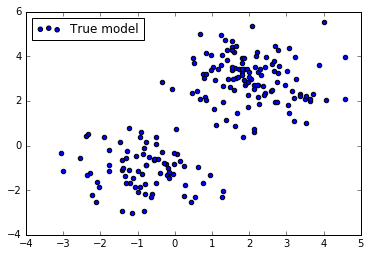

In [11]:
trueModel= models.MVGMM(np.array([[-1,-1],[2,3]]),np.array([np.eye(2), np.eye(2)]), [0.4, 0.6])


X = trueModel.sampleData(200)
pl.scatter(X[:,0], X[:,1], label='True model')
pl.legend(loc='upper left')

* The Normal-Gamma conjugate prior becomes the Normal-Wishart distribution (over unknown mean vector $mu$ and unknown precision matrix $\Lambda$):
$$
p( \boldsymbol{\mu, \Lambda} \mid \boldsymbol{m_0}, \kappa_0, \nu_0, \boldsymbol{\Lambda_0} )  = \Norm(\boldsymbol{\mu} \mid \boldsymbol{m_0}, (\kappa_0 \boldsymbol{\Lambda})^{-1}) \cdot W(\boldsymbol{\Lambda} \mid \boldsymbol{\Lambda_0}, \nu_0)
$$

It turns out that the posterior update equation for $\Lambda$ involves $\Lambda_0 ^{-1}$; since matrix is an expensive operation, we choose to work with the Normal-inverse-Wishart distribution:
$$
p( \boldsymbol{\mu, \Sigma} \mid \boldsymbol{m_0}, \kappa_0, \nu_0, \boldsymbol{S_0} )  = \Norm(\boldsymbol{\mu} \mid \boldsymbol{m_0}, \frac{\boldsymbol{\Sigma}}{\kappa_0}) \cdot IW(\boldsymbol{\Sigma} \mid \boldsymbol{S_0}, \nu_0)
$$
where $\Sigma$ is simply the inverse of $\Lambda$, and $\boldsymbol{m_0}$, $\kappa_0$, $\nu_0$, $\boldsymbol{\Lambda_0}$ are the hyperparameters.


Note that samples from a Normal-inverse-Wishart distribution are a pair of random (mean) vector and random (covariance) matrix.

In [12]:
m0 = np.array([1, 1])
k0 = 2
v0 = 3
S0 = np.eye(2)

niw = models.NormalInvWishart(m0,k0,v0,S0)
m, S = niw.sample()
print("Sample mean: " + str(m))
print("Sample variance: \n" +str(S))

Sample mean: [ 1.17190097  0.77083848]
Sample variance: 
[[ 1.82237329  1.74169154]
 [ 1.74169154  2.77385697]]


* The Bayesian update equations given evidence (or training data) $\boldsymbol{x}$ are the following:


$$
\begin{align}
\boldsymbol{m_N} &= \frac{\kappa_0 \boldsymbol{m_0} + N \boldsymbol{\bar{x}}} {\kappa_0 +  N}
\\
\kappa_N &= \kappa_0 + N \\
\nu_N &= \nu_0 + N \\
\boldsymbol{S_N} &= \boldsymbol{S_0} + \sum_n \boldsymbol{x_n x_n^T} + \kappa_0\boldsymbol{m_0 m_0^T} - \kappa_N \boldsymbol{m_N}\boldsymbol{m_N^T}\\
\boldsymbol{\bar{x}} &= \frac{1}{N} \sum_i x_i \\
\end{align}
$$

resulting in the posterior distribution (again a Normal-inverse-Wishart) $p(\boldsymbol{\mu, \Lambda} \mid \boldsymbol{x}) = NIW(\boldsymbol{\mu, \Lambda} \mid \boldsymbol{m_N} \kappa_N, \nu_N, \boldsymbol{S_N} ) $



## Collapsed Gibbs Sampling